In [89]:
#Importing necessary libraries
import numpy as np
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau,f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')
import os

In [90]:
#Read data
df = pd.read_csv('/Users/geet/Documents/Projects_Git/AB_testing/A-B-testing-on-gorcery-website/Data/website_data.csv')
df.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [91]:
df.shape

(184588, 5)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184588 entries, 0 to 184587
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   RecordID       184588 non-null  int64 
 1   IP Address     184588 non-null  object
 2   LoggedInFlag   184588 non-null  int64 
 3   ServerID       184588 non-null  int64 
 4   VisitPageFlag  184588 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 7.0+ MB


All the 184588 records are non null which means there no null values

In [93]:
df.isnull().sum()

RecordID         0
IP Address       0
LoggedInFlag     0
ServerID         0
VisitPageFlag    0
dtype: int64

There are 0 null values as expected

In [94]:
# Users who have visited the page multiple times using the same IP Address
df = df.groupby(["IP Address", "LoggedInFlag", "ServerID"])["VisitPageFlag"].sum().reset_index(name="VisitPageFlagSum")
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum
0,0.0.108.2,0,1,0
1,0.0.109.6,1,1,0
2,0.0.111.8,0,3,0
3,0.0.160.9,1,2,0
4,0.0.163.1,0,2,0


In [95]:
df['VisitPageFlagSum'].value_counts()

0    89785
1     9238
2      719
3       20
4        1
Name: VisitPageFlagSum, dtype: int64

9238 users as visited the page atleast once

In [96]:
#Statistics of Visits after grouping
df['VisitPageFlagSum'].describe()


count    99763.000000
mean         0.107655
std          0.334371
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: VisitPageFlagSum, dtype: float64

<AxesSubplot:>

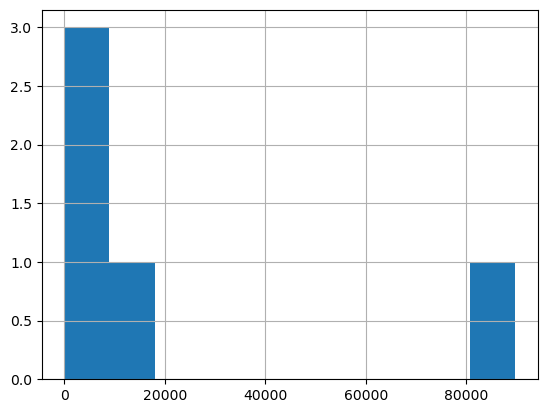

In [97]:
df['VisitPageFlagSum'].value_counts().hist()

From the histogram, it looks like 9000 plus users visit the page atleast once 

In [98]:
#Visit value is reduced to 1 for users who have visited the page multiple times using the same IP Address.
df["VisitPageFlag"] = df["VisitPageFlagSum"].apply(lambda x: 1 if x != 0 else 0)
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag
0,0.0.108.2,0,1,0,0
1,0.0.109.6,1,1,0,0
2,0.0.111.8,0,3,0,0
3,0.0.160.9,1,2,0,0
4,0.0.163.1,0,2,0,0


To ensure unbiased results, implemented a data preprocessing step where the Visit value is reduced to 1 for users who have visited the page multiple times using the same IP Address. By doing this, we avoid any potential skew in the analysis caused by multiple visits from the same user. This adjustment allows us to focus on unique visits and maintain the integrity of the experiment's outcome,

In [99]:
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag
0,0.0.108.2,0,1,0,0
1,0.0.109.6,1,1,0,0
2,0.0.111.8,0,3,0,0
3,0.0.160.9,1,2,0,0
4,0.0.163.1,0,2,0,0


To divide the dataset into Test and Control groups, utilized the ServerID attribute. The Test group is composed of instances with a ServerID of 1, while the Control group consists of instances with ServerID 2 and 3. This grouping strategy ensures that we have distinct segments for conducting the A/B test analysis. By assigning different server IDs to each group, we can accurately measure and compare the impact of the interface change (orange button) on user behavior between the Test and Control groups.

In [100]:
# The Test group is composed of instances with a ServerID of 1,
#while the Control group consists of instances with ServerID 2 and 3
df['group'] = df['ServerID'].map({1:'Test', 2:'Control', 3:'Control'})
df.drop(['ServerID','VisitPageFlagSum'],axis=1, inplace=True)

In [101]:
df.head()

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.108.2,0,0,Test
1,0.0.109.6,1,0,Test
2,0.0.111.8,0,0,Control
3,0.0.160.9,1,0,Control
4,0.0.163.1,0,0,Control


In [102]:
df_control = df[df['group'] == 'Control'].copy()
df_control.reset_index(inplace=True, drop = True)

In [103]:
df_control.head()

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.111.8,0,0,Control
1,0.0.160.9,1,0,Control
2,0.0.163.1,0,0,Control
3,0.0.178.9,1,0,Control
4,0.0.185.4,1,0,Control


In [104]:
df_test = df[df['group'] == 'Test'].copy()
df_test.reset_index(inplace=True, drop = True)


In [105]:
df_control

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.111.8,0,0,Control
1,0.0.160.9,1,0,Control
2,0.0.163.1,0,0,Control
3,0.0.178.9,1,0,Control
4,0.0.185.4,1,0,Control
...,...,...,...,...
66455,99.9.3.3,1,0,Control
66456,99.9.45.1,1,0,Control
66457,99.9.53.7,1,0,Control
66458,99.9.65.2,0,0,Control


In the control dataset, we will calculate the ratio of users who visit the specific page of interest to the total number of users who enter the website. This ratio, often referred to as the click-through rate (CTR), provides an indication of the effectiveness of the current interface (with the blue button) in driving user engagement.

To calculate the CTR in the control dataset, we will divide the number of visits to the desired page by the total number of visits to the website. This ratio will give us valuable insights into the proportion of users who navigate to the targeted page among all visitors to the site. By comparing this CTR with the CTR in the test dataset (where the interface has been modified to feature an orange button), we can assess the impact of the interface change on user behavior and determine if the new design leads to a higher click-through rate.

In [106]:
control_sum_visits = df_control['VisitPageFlag'].count()
print("Sum visits for control group: ", control_sum_visits)

Sum visit for control group:  66460


In [107]:
control_visit_1 = df_control[df_control['VisitPageFlag'] ==1]['VisitPageFlag'].count()
print("Visit Page target = 1 : ", control_visit_1)

Visit Page target = 1 :  6131


In [109]:
control_ratio_visits = control_visit_1/control_sum_visits
control_ratio_visits

0.09225097803189888

In the test group, we will also calculate the ratio of users who visit the specific page of interest to the total number of users who enter the website. This will allow us to compare the click-through rate (CTR) between the control group (with the blue button) and the test group (with the orange button) and determine the impact of the interface change on user engagement.

To calculate the CTR in the test group, we will follow the same approach as in the control group. We will divide the number of visits to the desired page within the test group by the total number of visits to the website within the test group. This ratio will provide us with insights into the proportion of users who navigate to the targeted page among all visitors within the test group.

By comparing the CTR in the control group with the CTR in the test group, we can evaluate the effectiveness of the interface change and determine if the modification to the button color has led to a significant difference in user behavior.

In [110]:
test_sum_visits = df_test['VisitPageFlag'].count()
print("Sum visits for test group: ", test_sum_visits)

Sum visits for test group:  33303


In [112]:
test_visit_1 = df_test[df_test['VisitPageFlag'] ==1]['VisitPageFlag'].count()
print("Visit Page target = 1 : ", test_visit_1)

Visit Page target = 1 :  3847


In [113]:
test_ratio_visits = test_visit_1/test_sum_visits
test_ratio_visits

0.11551511875806984

There is an observed difference in click rates between the two groups but to know the if the difference is statistically different, A/B test comes to the rercue


# A/B Test


To determine if there is a statistically significant difference between the control and test groups in terms of click rates, we will conduct A/B testing. A/B testing is a statistical method used to compare two groups and evaluate whether any observed differences are statistically significant or simply due to chance.

# Nomality test

To check the assumption of normality, we will perform a statistical test to determine if the data follows a normal distribution. This will help us decide which hypothesis test to apply for the A/B testing.

To test the assumption of normality, we can use methods such as the Shapiro-Wilk test or the Kolmogorov-Smirnov test. These tests evaluate whether the data significantly deviates from a normal distribution.

The hypotheses for testing normality are as follows:
H0: The data follows a normal distribution.
H1: The data does not follow a normal distribution.

By conducting the appropriate normality test on the dataset, we can assess whether the assumption of normality is satisfied. If the p-value of the test is greater than the significance level (e.g., 0.05), we fail to reject the null hypothesis and conclude that the data follows a normal distribution. In such cases, we can proceed with the independent two-sample t-test, assuming variance homogeneity is also satisfied.

However, if the data does not pass the normality test, we reject the null hypothesis and conclude that the data does not follow a normal distribution. In this situation, we would proceed with the Mann-Whitney U test, which is a non-parametric test that does not assume a normal distribution.

Performing these tests will provide us with valuable insights into whether the assumptions required for A/B testing are met, allowing us to confidently analyze and compare the results between the control and test groups.

In [114]:
test_stat_control, pvalue_control = shapiro(df_control["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat_control, pvalue_control))

Test Stat = 0.3266, p-value = 0.0000


In [115]:
test_stat_test, pvalue_test = shapiro(df_test["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat_test, pvalue_test))

Test Stat = 0.3711, p-value = 0.0000


The null hypothesis (H0) is rejected as the p-value is <0.05, indicating that the assumption of normality was not satisfied. Therefore, we will proceed with the Mann-Whitney U test.

H0: There is no significant difference between the two groups in terms of click rate to the target page.
H1: There is a difference.

In [116]:
test_stat, pvalue = mannwhitneyu(df_control["VisitPageFlag"],
                                 df_test["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


Test Stat = 1080913226.5000, p-value = 0.0000


The null hypothesis (H0) is rejected as the p-value is less than 0.05, indicating a statistically significant difference between the two groups.

In [117]:
group_count = df.groupby(['group', 'VisitPageFlag'])['group'].count().reset_index(name='Count')


In [118]:
#Creating a cross-tabulation table that summarizes the count of visitors in each group 
#who either entered or did not enter the desired page.
groupped = pd.crosstab(group_count['group'], group_count['VisitPageFlag'], values=group_count['Count'], aggfunc=np.sum, margins=True)

In [119]:
#calculates the percentage distribution of each value in the groupped contingency table 
#relative to the 'All' column, multiplied by 100.

100*groupped.div(groupped['All'], axis=0)


VisitPageFlag,0,1,All
group,,,
Control,90.774902,9.225098,100.0
Test,88.448488,11.551512,100.0
All,89.998296,10.001704,100.0


# Conclusion

The click-through rate in the Control group was 9.22%, while it increased to 11.55% in the Test group. Based on our statistical tests, 
we can conclude that this increase is not due to chance and is statistically significant. Hence, we can launch the application.

## The following are some suggested areas for further improvement in this A/B testing process:


1. Performing power analysis to determine the appropriate sample size for the experiment.
2. Considering effect sizes, confidence intervals, and practical significance.